In [6]:
# In[1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os
import glob  # For finding files

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook Configuration ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
pd.options.display.max_columns = 50
print("✅ Setup Complete: Libraries imported.")

# --- Project Paths (Relative to the `notebooks/` folder) ---
# '../' moves one directory up from 'notebooks/' to the main 'fec-european/' folder.
ROOT_DIR = '../' 
DATASETS_DIR = os.path.join(ROOT_DIR, 'datasets/')
PROCESSED_ARCHIVE_DIR = os.path.join(ROOT_DIR, 'data/processed_by_file/')
MODEL_INPUT_DIR = os.path.join(ROOT_DIR, 'data/model_input/')

# --- Source Data Directories (inside the `datasets` folder) ---
# This is the updated list you provided.
RAW_DATA_DIRECTORIES = [
    'spx_eod_2022q1-ff0r18/',
    'spx_eod_2022q2-bxgzw0/',
    'spx_eod_2022q3-1f2afi/',
    'spx_eod_2022q4-dmme3k/',
    'spx_eod_2023q1-cfph7w/',
    'spx_eod_2023q2-kdxt36/',
    'spx_eod_2023q3-w9b0jk/',
    'spx_eod_2023q4-ai4uc9/'
]

# --- Create output directories if they don't exist ---
os.makedirs(PROCESSED_ARCHIVE_DIR, exist_ok=True)
os.makedirs(MODEL_INPUT_DIR, exist_ok=True)
print(f"✅ Directories configured relative to the project root.")


✅ Setup Complete: Libraries imported.
✅ Directories configured relative to the project root.


In [7]:
# In[2]:
def process_spx_dataframe(df_raw):
    """
    Takes a raw SPX DataFrame and performs all cleaning, reshaping, and feature engineering.
    """
    # --- 1. Reshape from wide to long format ---
    base_cols = ['QUOTE_DATE', 'EXPIRE_DATE', 'UNDERLYING_LAST', 'STRIKE', 'DTE']
    call_cols = {'C_BID': 'bid', 'C_ASK': 'ask', 'C_IV': 'iv', 'C_VOLUME': 'volume', 'C_DELTA': 'delta'}
    put_cols = {'P_BID': 'bid', 'P_ASK': 'ask', 'P_IV': 'iv', 'P_VOLUME': 'volume', 'P_DELTA': 'delta'}

    df_calls = df_raw[base_cols + list(call_cols.keys())].rename(columns=call_cols)
    df_calls['option_type'] = 'C'
    
    df_puts = df_raw[base_cols + list(put_cols.keys())].rename(columns=put_cols)
    df_puts['option_type'] = 'P'

    df_long = pd.concat([df_calls, df_puts], ignore_index=True)

    # --- 2. Initial Cleaning & Price Calculation ---
    df_long['mid_price'] = (df_long['bid'] + df_long['ask']) / 2.0
    df_long.dropna(subset=['iv', 'mid_price', 'DTE', 'STRIKE'], inplace=True)
    df_long = df_long[(df_long['iv'] > 0) & (df_long['mid_price'] > 0.05) & (df_long['DTE'] >= 0)]

    # --- 3. Feature Engineering ---
    df_long['T_years'] = df_long['DTE'] / 365.0
    df_long['moneyness'] = df_long['UNDERLYING_LAST'] / df_long['STRIKE']
    df_long['risk_free_rate'] = 0.03 # Placeholder

    # --- 4. Final Liquidity Filtering ---
    df_final = df_long[
        (df_long['T_years'] > 7/365.0) & (df_long['T_years'] < 1.5) &
        (df_long['moneyness'] > 0.85) & (df_long['moneyness'] < 1.15) &
        (df_long['volume'] >= 1)
    ].copy()
    
    return df_final

print("✅ Data Processing Module defined.")

✅ Data Processing Module defined.


In [8]:
# In[3]:
# Define column names from your data header
columns = [
    'QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS', 'UNDERLYING_LAST', 'EXPIRE_DATE', 
    'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 
    'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE', 'P_LAST', 'P_DELTA', 'P_GAMMA', 
    'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'
]

all_raw_files = []
print("Searching for raw data files in specified directories...")
for directory in RAW_DATA_DIRECTORIES:
    # Build the search path inside the ../datasets/ folder
    search_path = os.path.join(DATASETS_DIR, directory, '*.txt')
    found_files = glob.glob(search_path)
    if not found_files:
        print(f"    - ⚠️ No .txt files found in '{search_path}'")
    all_raw_files.extend(found_files)

unique_raw_files = sorted(list(set(all_raw_files)))

print(f"\nFound {len(unique_raw_files)} unique raw files. Starting processing and archiving...\n")

# Loop through each file, process it, and save it to the new mirrored structure
for file_path in unique_raw_files:
    # --- 1. Load a single raw file ---
    df_raw_single = pd.read_csv(file_path, skiprows=1, names=columns, skipinitialspace=True)
    
    for col in ['QUOTE_DATE', 'EXPIRE_DATE']:
        df_raw_single[col] = pd.to_datetime(df_raw_single[col], errors='coerce')
    numeric_cols = [col for col in columns if col not in ['QUOTE_DATE', 'EXPIRE_DATE', 'QUOTE_READTIME', 'C_SIZE', 'P_SIZE']]
    for col in numeric_cols:
        df_raw_single[col] = pd.to_numeric(df_raw_single[col], errors='coerce')

    # --- 2. Process the DataFrame ---
    df_processed = process_spx_dataframe(df_raw_single)
    
    # --- 3. Create the corresponding output path ---
    relative_path = os.path.relpath(file_path, DATASETS_DIR)
    output_path = os.path.join(PROCESSED_ARCHIVE_DIR, relative_path)
    output_path = os.path.splitext(output_path)[0] + '.csv' # Change extension to .csv
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # --- 4. Save the processed file as CSV ---
    if not df_processed.empty:
        df_processed.to_csv(output_path, index=False)
        print(f"    - Processed '{os.path.basename(file_path)}' -> Saved to '{output_path}'")
    else:
        print(f"    - Skipped '{os.path.basename(file_path)}' (no valid data after filtering)")

print("\n✅ All files processed and saved to the mirrored archive directory as CSVs.")


Searching for raw data files in specified directories...

Found 24 unique raw files. Starting processing and archiving...

    - Processed 'spx_eod_202201.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q1-ff0r18/spx_eod_202201.csv'
    - Processed 'spx_eod_202202.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q1-ff0r18/spx_eod_202202.csv'
    - Processed 'spx_eod_202203.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q1-ff0r18/spx_eod_202203.csv'
    - Processed 'spx_eod_202204.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q2-bxgzw0/spx_eod_202204.csv'
    - Processed 'spx_eod_202205.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q2-bxgzw0/spx_eod_202205.csv'
    - Processed 'spx_eod_202206.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q2-bxgzw0/spx_eod_202206.csv'
    - Processed 'spx_eod_202207.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q3-1f2afi/spx_eod_202207.csv'
    - Processed 'spx_eod_202208.txt' -> Saved to '.

--- Merged 24 processed files for analysis ---
<class 'pandas.core.frame.DataFrame'>
Index: 2874621 entries, 1096108 to 2176775
Data columns (total 15 columns):
 #   Column           Dtype         
---  ------           -----         
 0   QUOTE_DATE       datetime64[ns]
 1   EXPIRE_DATE      datetime64[ns]
 2   UNDERLYING_LAST  float64       
 3   STRIKE           float64       
 4   DTE              float64       
 5   bid              float64       
 6   ask              float64       
 7   iv               float64       
 8   volume           float64       
 9   delta            float64       
 10  option_type      object        
 11  mid_price        float64       
 12  T_years          float64       
 13  moneyness        float64       
 14  risk_free_rate   float64       
dtypes: datetime64[ns](2), float64(12), object(1)
memory usage: 350.9+ MB
None


/var/folders/n_/dnf6kyg149s2jmmkx_1w3vbr0000gn/T/ipykernel_79827/4184682228.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_clean_merged.set_index('QUOTE_DATE')['STRIKE'].resample('M').count().plot(kind='bar')


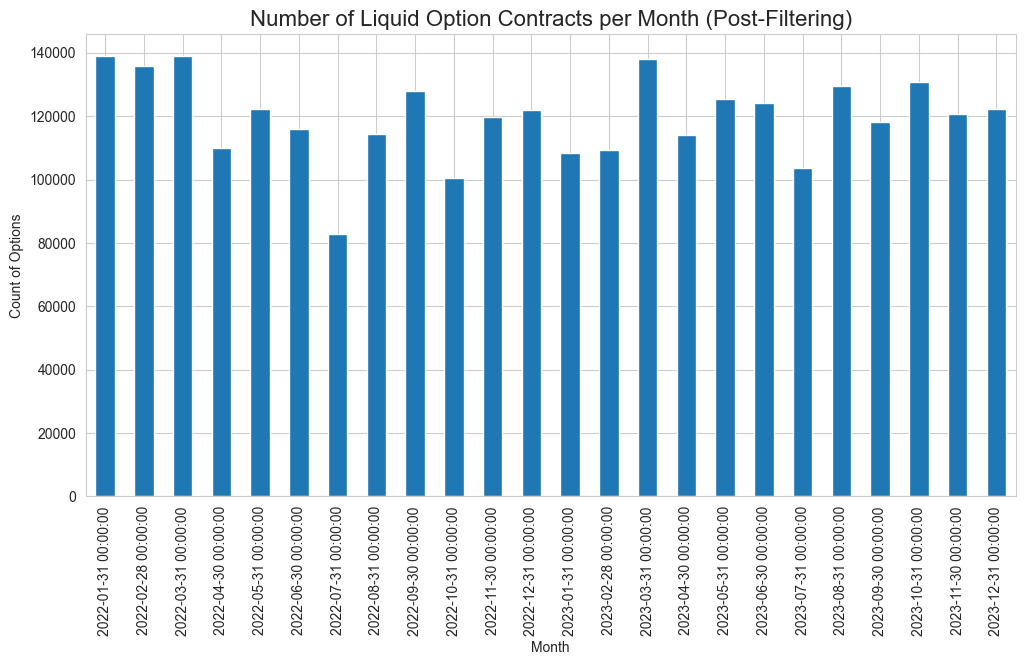


--- Descriptive Statistics of Final Dataset ---
            T_years     moneyness            iv        volume
count  2.874621e+06  2.874621e+06  2.874621e+06  2.874621e+06
mean   2.386120e-01  1.008326e+00  1.966305e-01  4.292923e+01
std    2.678038e-01  6.805925e-02  5.944549e-02  2.504521e+02
min    1.928767e-02  8.500019e-01  1.000000e-05  1.000000e+00
25%    5.479452e-02  9.629471e-01  1.547800e-01  1.000000e+00
50%    1.232877e-01  1.007436e+00  1.957200e-01  4.000000e+00
75%    3.261370e-01  1.056251e+00  2.360300e-01  1.600000e+01
max    1.498740e+00  1.149994e+00  6.921700e-01  7.802600e+04


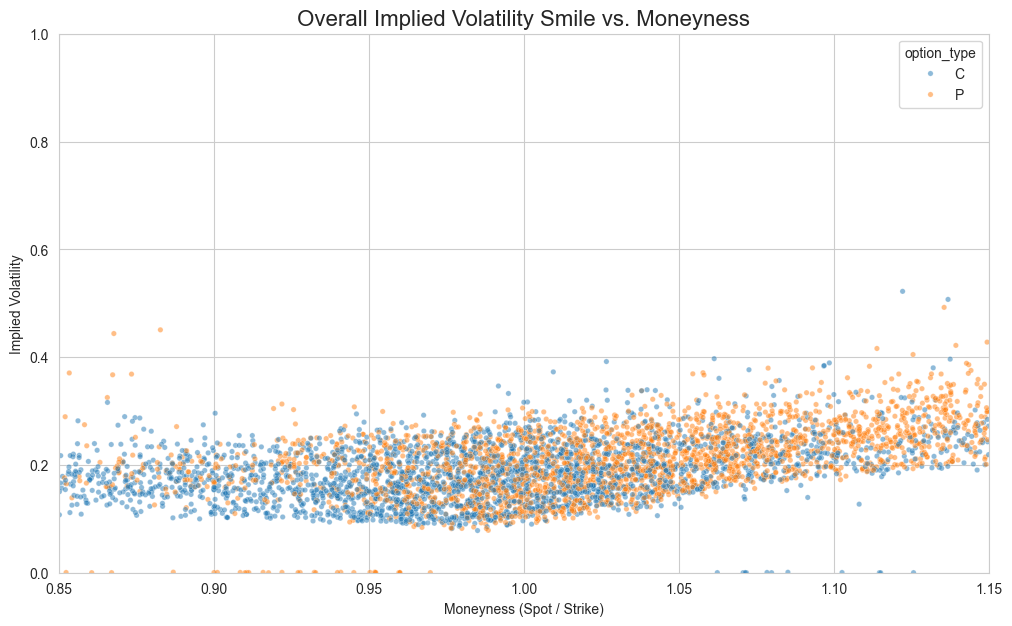

In [9]:
# In[4]:
# --- Load all the newly processed .csv files ---
search_pattern_processed = os.path.join(PROCESSED_ARCHIVE_DIR, '**/*.csv')
all_processed_files = glob.glob(search_pattern_processed, recursive=True)

if not all_processed_files:
    print("⚠️ No processed files found to merge for EDA. Please run the previous cell.")
else:
    # Load all CSVs into a list of DataFrames
    df_list = [pd.read_csv(f, parse_dates=['QUOTE_DATE', 'EXPIRE_DATE']) for f in all_processed_files]
    df_clean_merged = pd.concat(df_list, ignore_index=True)
    df_clean_merged.sort_values('QUOTE_DATE', inplace=True)
    
    print(f"--- Merged {len(all_processed_files)} processed files for analysis ---")
    print(df_clean_merged.info())

    # --- Perform EDA on the complete, clean dataset ---
    plt.figure(figsize=(12, 6))
    df_clean_merged.set_index('QUOTE_DATE')['STRIKE'].resample('M').count().plot(kind='bar')
    plt.title('Number of Liquid Option Contracts per Month (Post-Filtering)', fontsize=16)
    plt.ylabel('Count of Options')
    plt.xlabel('Month')
    plt.show()

    print("\n--- Descriptive Statistics of Final Dataset ---")
    print(df_clean_merged[['T_years', 'moneyness', 'iv', 'volume']].describe())
    
    # --- IV Smile on the full dataset (using a sample to avoid overplotting) ---
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_clean_merged.sample(n=min(5000, len(df_clean_merged))), x='moneyness', y='iv', hue='option_type', alpha=0.5, s=15)
    plt.title('Overall Implied Volatility Smile vs. Moneyness', fontsize=16)
    plt.xlabel('Moneyness (Spot / Strike)')
    plt.ylabel('Implied Volatility')
    plt.xlim(0.85, 1.15)
    plt.ylim(0, 1.0)
    plt.show()

In [10]:
# In[5]:
def split_and_save_modeling_data(df, features, target, output_dir):
    """
    Performs a final chronological split and saves data for modeling.
    """
    print("\n--- Splitting and Saving Final Modeling Datasets ---")
    
    df = df.sort_values('QUOTE_DATE').reset_index(drop=True)
    
    # Chronological Split (70% Train, 15% Validation, 15% Test)
    train_size = int(len(df) * 0.70)
    val_size = int(len(df) * 0.15)
    
    df_train = df.iloc[:train_size]
    df_val = df.iloc[train_size : train_size + val_size]
    df_test = df.iloc[train_size + val_size :]

    # Create separate objects for features and target
    X_train, y_train = df_train[features], df_train[target]
    X_val, y_val = df_val[features], df_val[target]
    X_test, y_test = df_test[features], df_test[target]
    
    # Save to the dedicated modeling directory as CSV
    for name, data in {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}.items():
        data.to_csv(os.path.join(output_dir, f'{name}.csv'), index=False)
        
    print(f"✅ Modeling datasets saved to '{output_dir}'. Ready for training.")

# --- Define final features and target ---
feature_cols = ['T_years', 'moneyness', 'risk_free_rate']
target_col = 'iv'

# --- Execute final split and save ---
if 'df_clean_merged' in locals() and not df_clean_merged.empty:
    split_and_save_modeling_data(df_clean_merged, feature_cols, target_col, MODEL_INPUT_DIR)
else:
    print("⚠️ Skipping final split because the merged dataframe is not available.")


--- Splitting and Saving Final Modeling Datasets ---
✅ Modeling datasets saved to '../data/model_input/'. Ready for training.
